# Group 14 - Project FP01
## Time series anomaly detection

This project aims at investigating the current state-of-the-arts TAD scenario.

In [4]:
!pip install pandas==1.5.3
!pip install tsfel
!pip install keras_tuner

In [5]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty
from bayesian_model import BayesianMLPClassifier
from metrics import Confidence, anomaly_detection_metric

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

Mounted at /content/drive


In [6]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY =  '/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

In [7]:
# Dataset frequency
freq_1s = '1'
freq_01s = '0.1'
freq_001s = '0.01'
freq_0005s = '0.005'

### Data Loading

In [8]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [9]:
fig = go.Figure()
signals = [
    "sensor_id1_AngY",
    "sensor_id2_AngX",
    "sensor_id5_AngY",
    "sensor_id4_AccZ",
    "sensor_id4_AngX",
    "machine_nameKuka Robot_power"]

start = df.index[9000]
df_reduced = df.loc[start:]
duration = 120  # seconds
time_delta = df_reduced.index - start
df_interval = df_reduced[time_delta.total_seconds() <= duration]
j = 0

# Leveraging plotly express
n_colors = len(signals)
colors = px.colors.sample_colorscale("greys", [n/(n_colors -1) for n in range(n_colors)])  # From continuous colormap
colors = px.colors.qualitative.Set2  # From discrete colormap, see https://plotly.com/python/discrete-color/
df_signals = df_interval[signals].select_dtypes(['number'])
df_signals = df_signals / df_signals.max()
fig = px.line(df_signals, x=df_signals.index, y=df_signals.columns, color_discrete_sequence=colors)

# Leveraging plotly graph object
colors_action = px.colors.qualitative.Antique
j = 0
for action in df_action.loc[df_interval.index].action.unique():
    df_action_interval = df_action.loc[df_interval.index]
    df_action_single_action = df_action_interval[df_action_interval['action'] == action]
    fig.add_trace(go.Scatter(
        x=df_action_single_action.index,
        y=[-0.3] * len(df_action_single_action.index),
        line_shape="hv",
        line=dict(color=colors_action[j], width=2.5),
        name=action))
    j += 1


fig.update_layout(
    title="Some signals",
    xaxis_title="Time",
    yaxis_title="",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Black"
    )
)
fig.show()

In [10]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 230.7608664035797 seconds ---


X_train shape: (729, 2200)
y_train shape: (729,)
X_test shape: (244, 2200)
y_test shape: (244,)


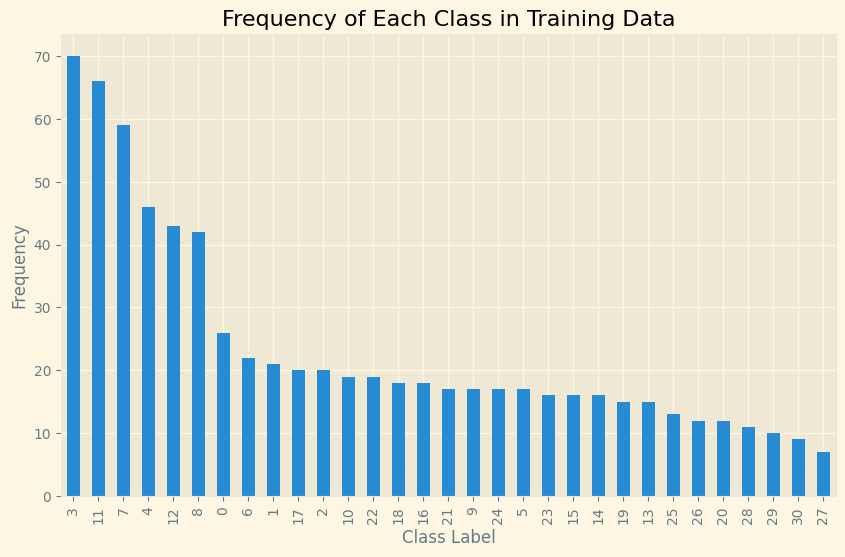

X_train shape: (729, 72)
y_train categorical shape: (729, 31)
y_train shape: (729,)
X_test shape: (244, 72)
y_test shape: (244,)


In [11]:
df_features.isnull().values.any()
# df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
df_features_nonan = df_features.fillna(0)
df_train, df_test = train_test_split(df_features_nonan)
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Count the occurrence of each class
label_counts = y_train.value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Frequency of Each Class in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train categorical shape: {y_train_categorical.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

input_shape = (X_train.values.shape[1],)
num_classes = len(y_train_categorical[0])

### Bayesian MLP for Anomaly Detection from Lab 7

In [12]:
clf = BayesianMLPClassifier(input_shape, num_classes)
clf.setup_tuner()

clf.search(X_train.values, y_train_categorical)
y_test_pred = clf.predict(X_test.values)

Trial 90 Complete [00h 00m 07s]
accuracy: 0.30041152238845825

Best accuracy So Far: 0.9122084975242615
Total elapsed time: 00h 05m 20s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72)]              0         
                                                                 
 dense (Dense)               (None, 64)                4672      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 96)                62

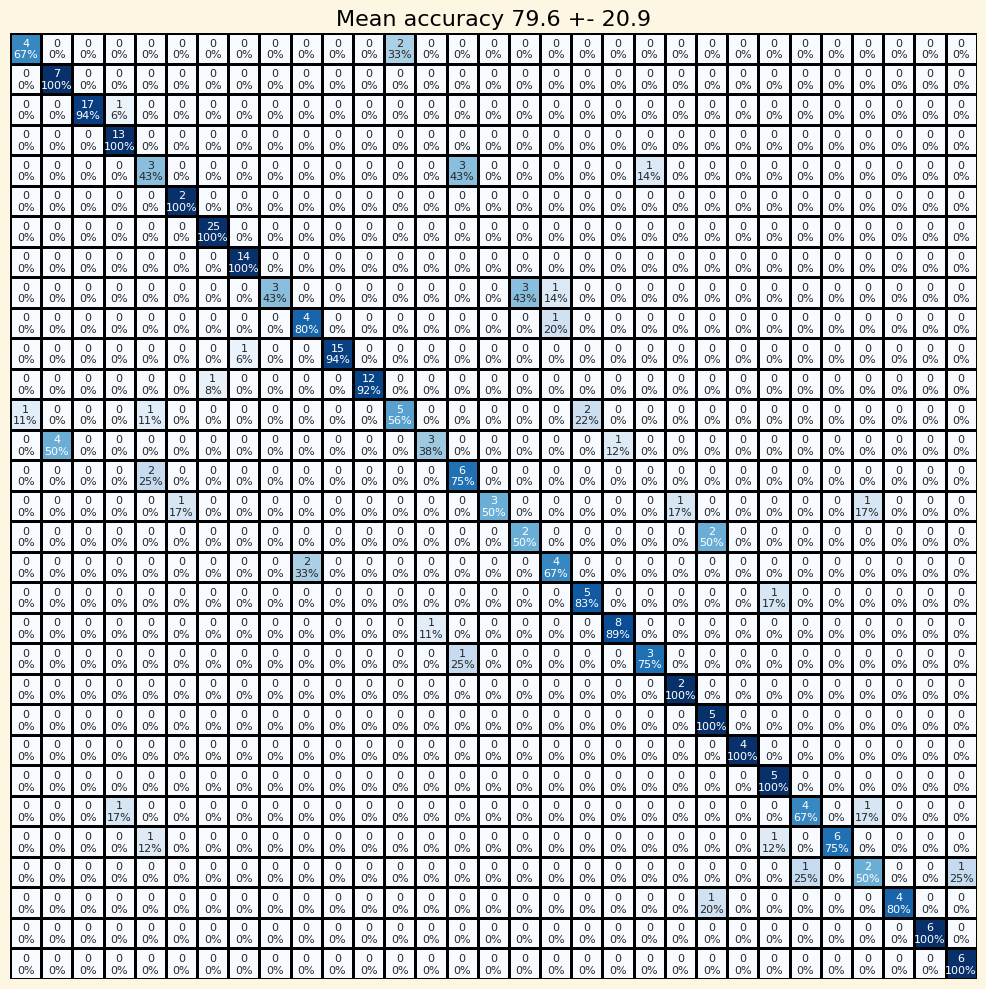

In [14]:
create_and_plot_cm(y_test_pred, y_test, action2int)

(10, 244, 31)
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


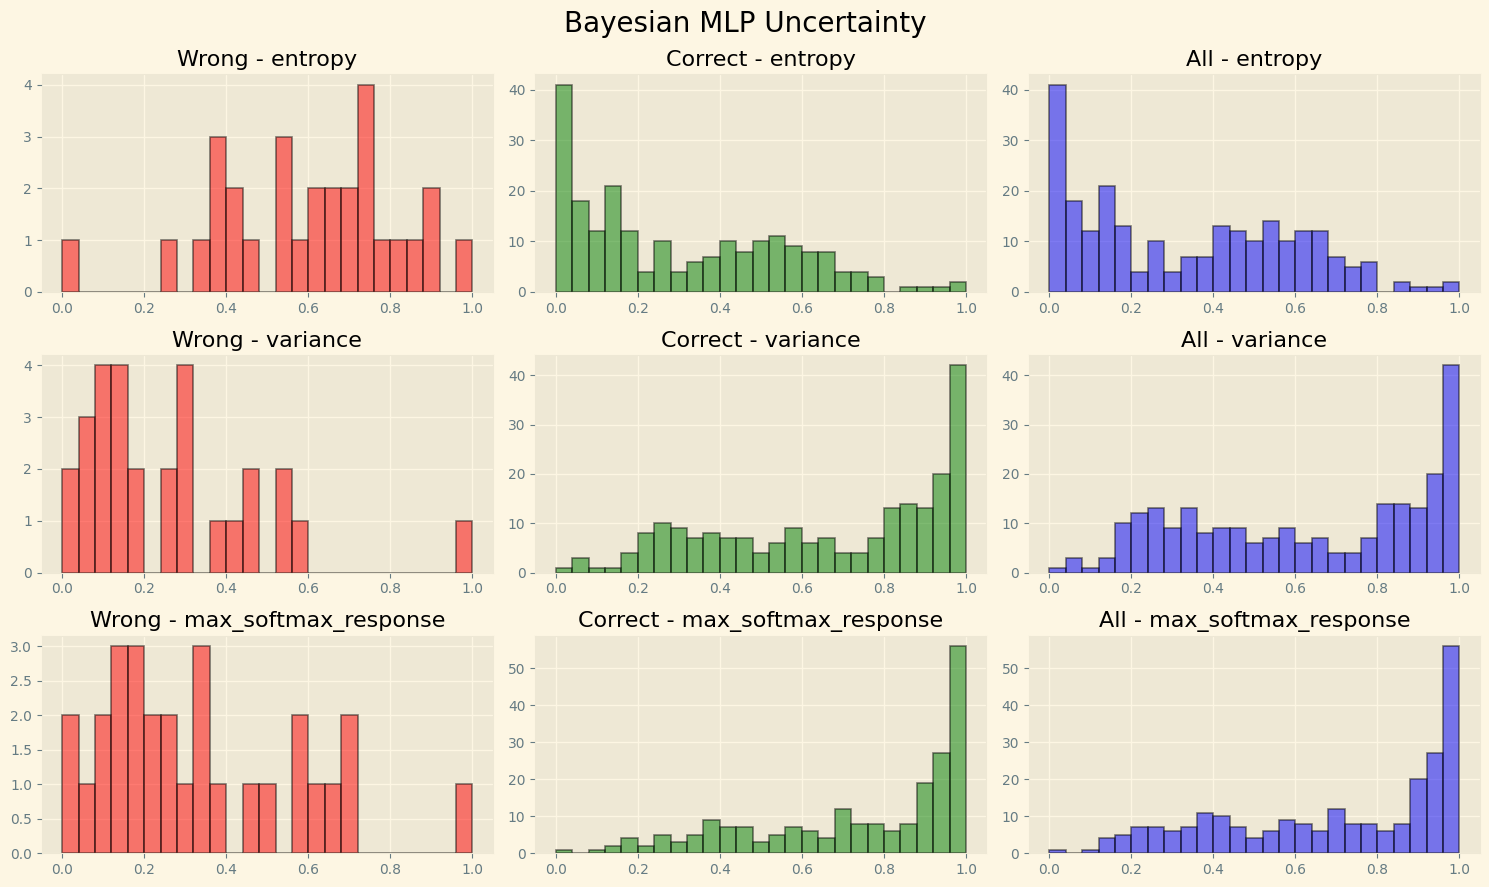

In [15]:
n_mc = 10
preds_list = [clf.model.predict(X_test.values, verbose=0) for _ in range(n_mc)]
preds_array = np.array(preds_list)
print(preds_array.shape)
preds_bayes_mean = np.mean(preds_array, axis=0)

uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

In [16]:
# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_pred_classes = y_test_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8278688524590164
Precision: 0.7937751316783576
Recall: 0.795643290401355
F1 Score: 0.7777759869719416


# Anomaly detection

In [19]:
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 84.38306641578674 seconds ---


10/10 [==============================] - 0s 3ms/step
Accuracy: 0.6503267973856209
Precision: 0.6525738914258838
Recall: 0.6071475507765831
F1 Score: 0.5977331944867018
(10, 306, 31)
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


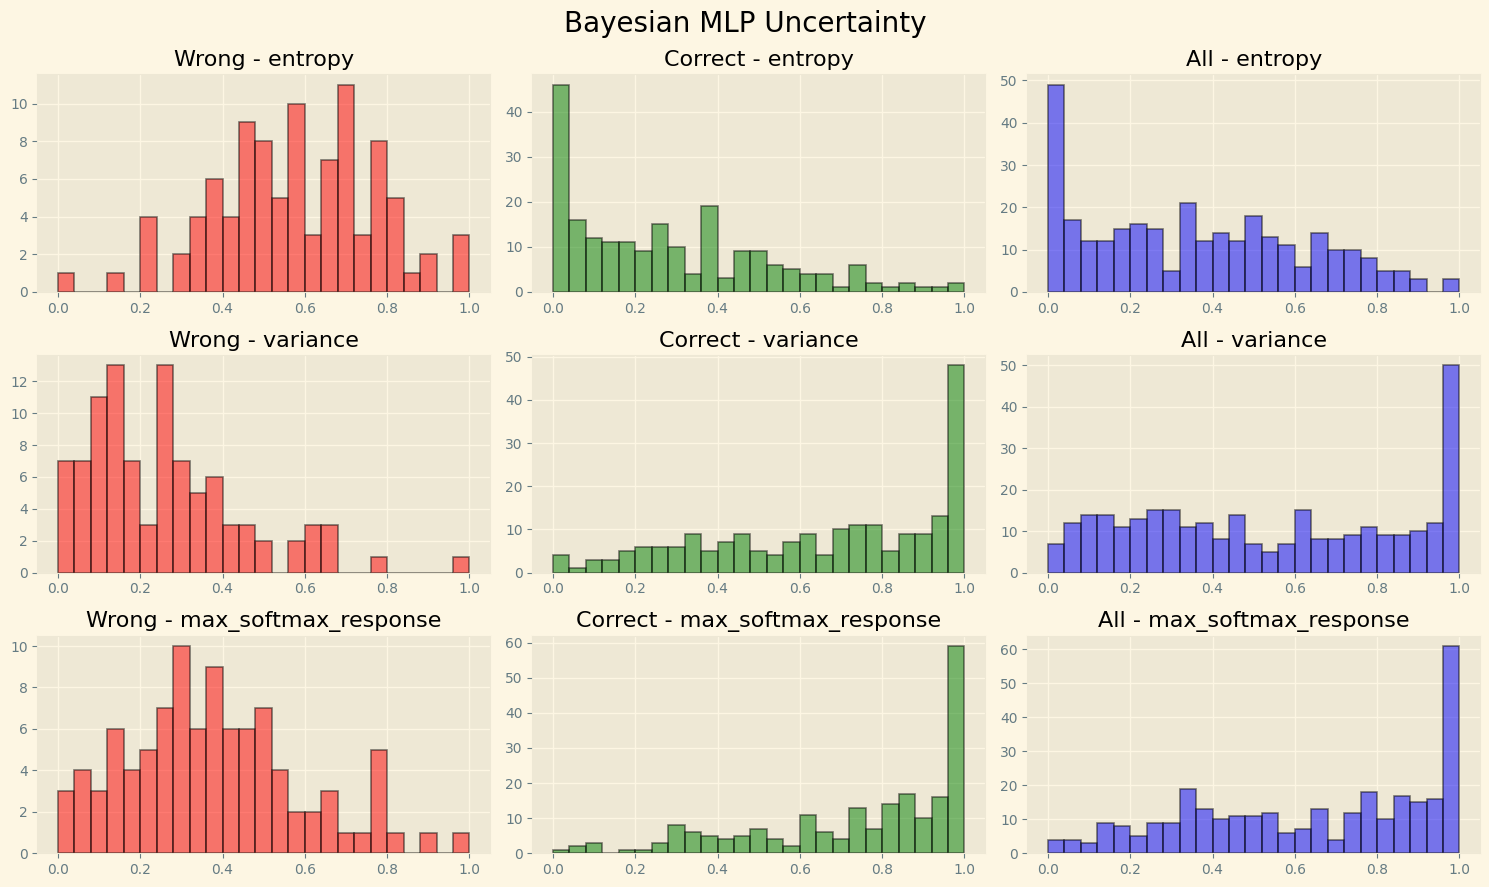

In [20]:
df_features_collision.isnull().values.any()
df_features_collision_nonan = df_features_collision.fillna(0)

X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_test_pred_collision = clf.predict(X_collision.values)
y_pred_classes = y_test_pred_collision.argmax(axis=1)

accuracy = accuracy_score(y_collision, y_pred_classes)
precision = precision_score(y_collision, y_pred_classes, average='macro')
recall = recall_score(y_collision, y_pred_classes, average='macro')
f1 = f1_score(y_collision, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

preds_list_collision = [clf.model.predict(X_collision.values, verbose=0) for _ in range(n_mc)]
preds_array_collisions = np.array(preds_list_collision)
print(preds_array_collisions.shape)
preds_bayes_mean_collision = np.mean(preds_array_collisions, axis=0)

uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()

plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.32      1.00      0.48        12
           1       0.83      0.50      0.62        10
           2       0.50      0.22      0.31         9
           3       0.94      0.63      0.76        27
           4       0.94      0.83      0.88        18
           5       1.00      0.11      0.20         9
           6       0.83      0.56      0.67         9
           7       0.93      0.96      0.95        27
           8       1.00      0.72      0.84        18
           9       0.50      0.22      0.31         9
          10       1.00      0.44      0.62         9
          11       0.75      0.84      0.79        25
          12       1.00      0.75      0.86        16
          13       0.38      0.83      0.53         6
          14       1.00      0.17      0.29         6
          15       0.60      0.50      0.55         6
          16       0.75      0.50      

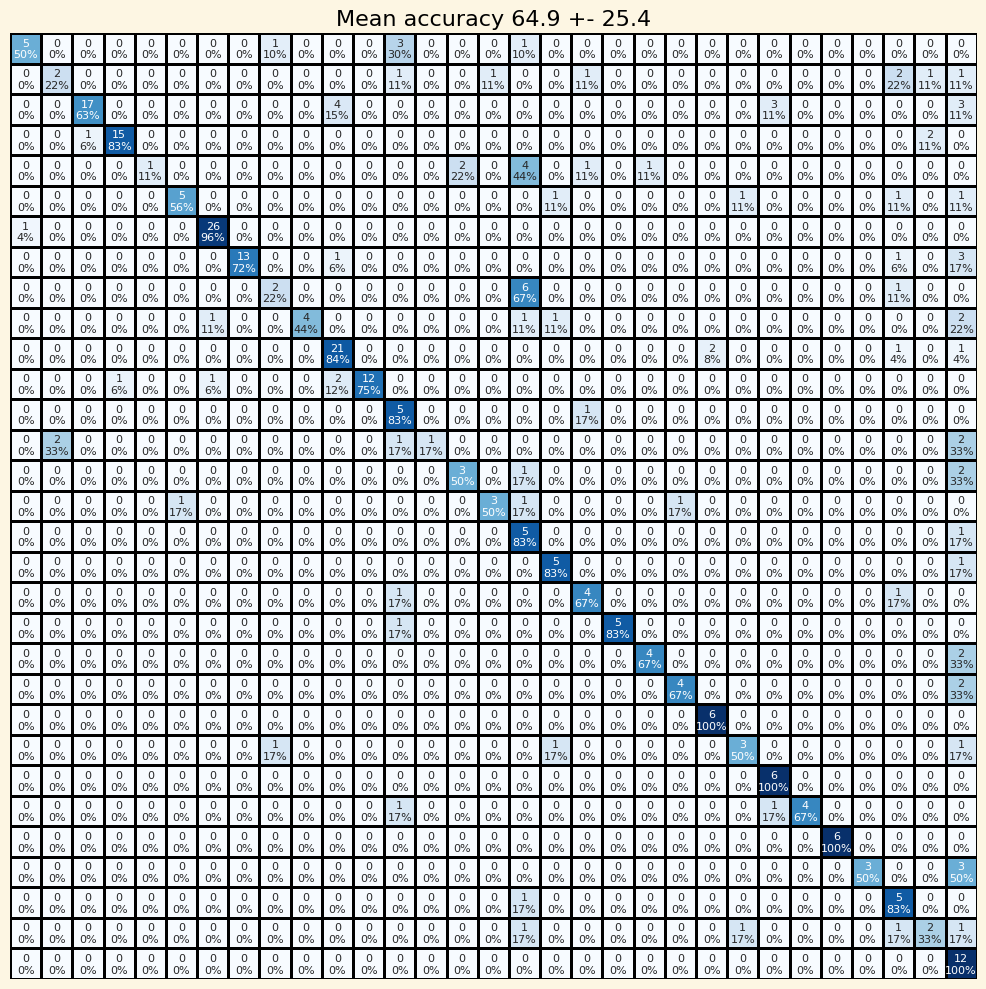

In [22]:
# Assuming you have y_collision as the true labels for the collision dataset
y_pred_collision_classes = preds_bayes_mean_collision.argmax(axis=1)

print("Confusion Matrix:")
create_and_plot_cm(preds_bayes_mean_collision, y_collision, action2int)

print("\nClassification Report:")
print(classification_report(y_collision, y_pred_collision_classes))

[0.0, -0.005025125628140614, 0.0, 0.01005025125628145, 0.09547738693467334, 0.15577889447236182, 0.23115577889447236, 0.31658291457286436, 0.44221105527638194, 0.6030150753768844]
[0.009345794392523364, 0.09345794392523364, 0.2616822429906542, 0.4205607476635514, 0.5981308411214953, 0.719626168224299, 0.8130841121495327, 0.8691588785046729, 0.9252336448598131, 0.9626168224299065]


ValueError: x is neither increasing nor decreasing : [ 0.         -0.00502513 -0.00502513  0.01005025  0.03517588  0.11557789
  0.2160804   0.35175879  0.49748744  0.65326633].

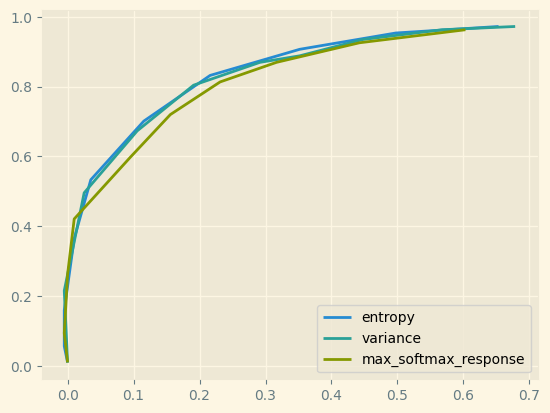

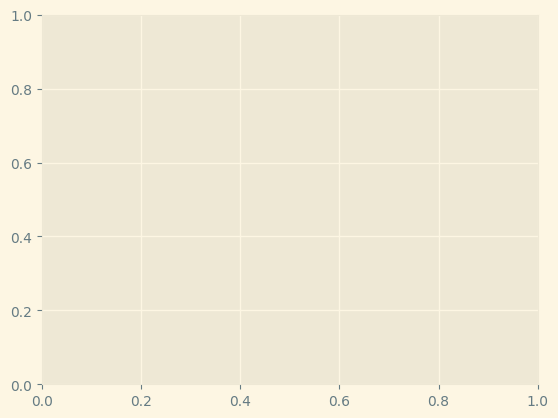

In [23]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)


fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

fig, ax = plt.subplots()
print(fpr)
print(sens)

for confidence_metric, (fpr, sens) in roc_dict.items():
    ax.plot(fpr, sens, label=f'{confidence_metric} (AUC: {auc(fpr, sens):.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Uncertainty Metric')
ax.legend(loc='lower right')
plt.show()

y_pred_collision = clf.predict(X_collision.values)
y_pred_collision_classes = y_pred_collision.argmax(axis=1)
missclassified = y_collision != y_pred_collision_classes
print(f"Missclassified samples: {missclassified}")
print(f"Number of Missclassified samples: {missclassified.sum()}")

total_collision = len(collisions_init)

print(f"Total number of collisions: {total_collision}")